In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
import sys
sys.path.append('.venv/lib/python3.7/site-packages/')

In [2]:
import torch
import torch.nn as nn
import torchvision
from common.logging import TensorBoardLogger
from common.transformation import RolloutImage
from model import TDVAE
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [3]:
# Load MNIST dataset. We will use the training data only because our task so far is to evaluate rollout not to 
# classify the numbers
training_set = torchvision.datasets.MNIST('data/', 
                                          train=True, 
                                          download=True, 
                                          transform=torchvision.transforms.Compose([
                                              torchvision.transforms.ToTensor(),
                                              RolloutImage(time_steps=20),
                                              torchvision.transforms.Lambda(lambda x: torch.flatten(x, start_dim=1))
                                          ]))
                                            

In [4]:
logger = TensorBoardLogger(out_dir='board', 
                           update_frequency_type='batch', 
                           update_frequency=50,
                           image_transforms={'x_t2': lambda x : x[0].reshape(28, 28).unsqueeze(0)})

In [5]:
# Preserving the original parameters given in the paper
model = TDVAE(belief_size=50, 
              latent_size=8, 
              d_map_size=50,
              obs_size=28*28,
              minified_obs_size=28*28,
              decoder_activation='relu',
              decoder_hidden_dims=[200, 200, 200],
              pre_processing_activation='tanh',
              pre_processing_hidden_dims=[28*28, 28*28])
print(model)
# model = model.cuda()

TDVAE(
  (_pre_processing_nn): MLP(
    (_neural_network): Sequential(
      (0): Linear(in_features=784, out_features=784, bias=True)
      (1): Tanh()
      (2): Linear(in_features=784, out_features=784, bias=True)
      (3): Tanh()
      (4): Linear(in_features=784, out_features=784, bias=True)
      (5): Tanh()
    )
  )
  (_belief_nn): MultilayerLSTM(
    (_lstm_cell): MultilayerLSTMCell(
      (_lstm_cells): ModuleList(
        (0): LSTMCell(834, 50)
        (1): LSTMCell(50, 50)
      )
    )
  )
  (_l2_belief_to_latent): GaussianNN(
    (_distribution_params_nns): ModuleList(
      (0): Linear(in_features=50, out_features=8, bias=True)
      (1): Linear(in_features=50, out_features=8, bias=True)
    )
    (_tanh_path): Sequential(
      (0): Linear(in_features=50, out_features=50, bias=True)
      (1): Tanh()
    )
    (_sigmoid_path): Sequential(
      (0): Linear(in_features=50, out_features=50, bias=True)
      (1): Sigmoid()
    )
  )
  (_l1_belief_to_latent): GaussianNN(
 

In [ ]:
loss = model.fit(training_set=training_set, 
          epochs=20, 
          batch_size=64,
          optimizer=torch.optim.Adam(model.parameters(), lr=1e-3),
          callbacks=[logger],
          max_t1=5,
          max_time_step=3)



[01/20]:  37%|###7      | 350/938 [01:34<02:38,  3.71it/s, loss=-18.3]

In [ ]:
loss

In [13]:
make_dot(loss, params=dict(list(model.named_parameters()))).render("loss", format="png")

KeyboardInterrupt: 

In [7]:
test = training_set.data[:5].clone().detach() / 255.
rollout = RolloutImage(10, 1)
imgs = []
for i in range(test.size(0)): 
    img = rollout(torch.unsqueeze(test[i], dim=0))
    img = torch.flatten(img, start_dim=1)
    imgs.append(img)
test = torch.stack(imgs, dim=0)    

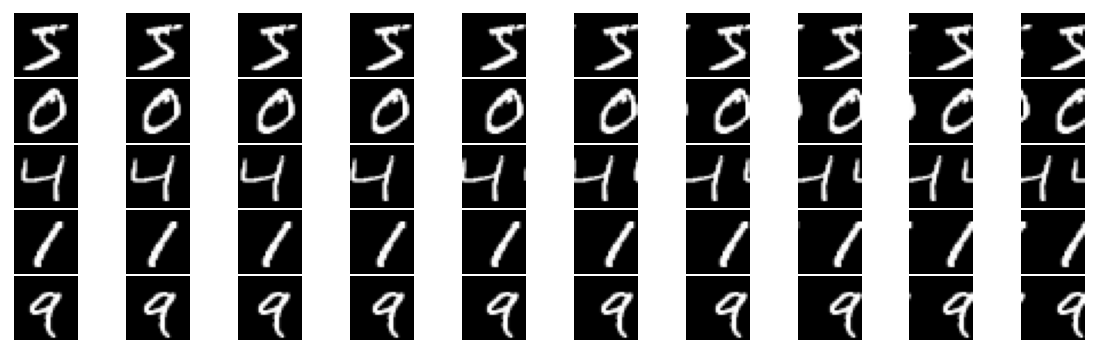

In [8]:
fig = plt.figure(0, figsize = (10,3))
fig.clf()
gs = gridspec.GridSpec(test.size(0),test.size(1))
gs.update(wspace = 0.025, hspace = 0.025)

for i in range(test.size(0)):
    img = test[i]
    for n in range(test.size(1)):
        axes = plt.subplot(gs[i,n])
        axes.imshow(img[n,:].reshape(28,28), cmap = 'gray')
        axes.axis('off')
plt.show()

In [10]:
future = model.rollout(test, 10)

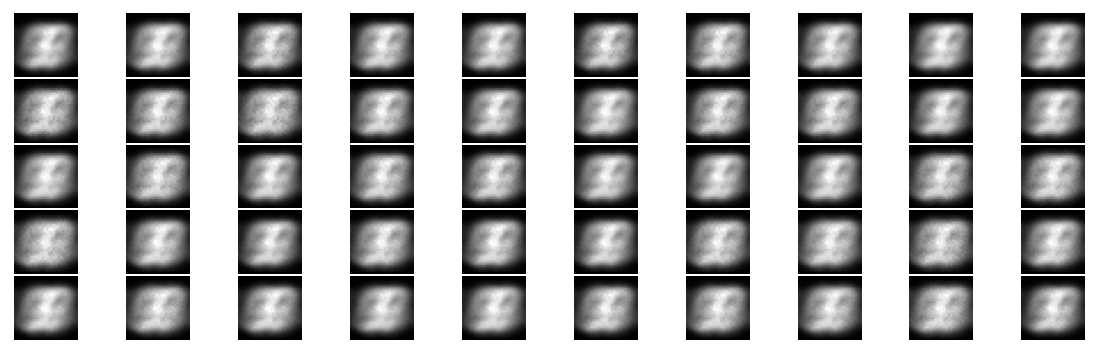

In [11]:
fig = plt.figure(0, figsize = (10,3))
fig.clf()
gs = gridspec.GridSpec(future.size(0),future.size(1))
gs.update(wspace = 0.025, hspace = 0.025)

for i in range(future.size(0)):
    img = future[i]
    for n in range(future.size(1)):
        axes = plt.subplot(gs[i,n])
        axes.imshow(img[n,:].reshape(28,28), cmap = 'gray')
        axes.axis('off')
plt.show()

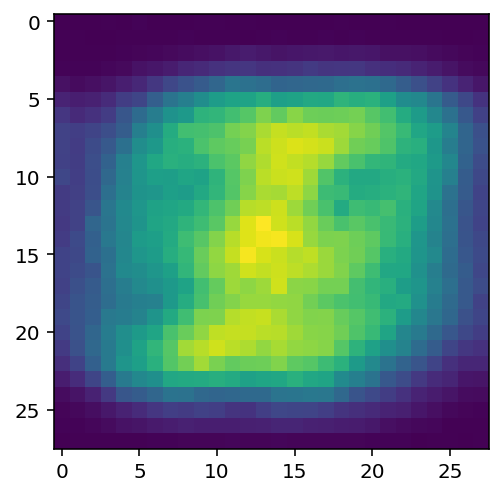

In [16]:
plt.imshow(future[0][0].reshape(28,28))

In [30]:
test[0][0]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

In [24]:
from common import calculate_gaussian_kl_divergence
mu_q = torch.tensor([[2]])
log_var_q = torch.log(torch.tensor([[3]]))
mu_p = torch.tensor([[4]])
log_var_p = torch.log(torch.tensor([[5]]))
calculate_gaussian_kl_divergence([mu_q, log_var_q], [mu_p, log_var_p])

tensor([0.2708])

In [25]:
q = torch.distributions.normal.Normal(mu_q, torch.exp(log_var_q))
p = torch.distributions.normal.Normal(mu_p, torch.exp(log_var_p))
torch.distributions.kl.kl_divergence(q, p)

tensor([[0.2708]])